In [2]:
import pandas as pd
import nltk
from gensim.models import KeyedVectors

import sys 
sys.path.append('/Users/jessicahassibi/PycharmProjects/bachelor-thesis/src/models')
import ttl_word2vec
import classification

In [164]:
from importlib import reload
reload(ttl_word2vec)
reload(classification)

<module 'classification_helpers' from '/Users/jessicahassibi/PycharmProjects/bachelor-thesis/src/models/classification_helpers.py'>

## Methods to get Word Embeddings

In [5]:
# load dataframe
en_df_cleaned = pd.read_csv(f'../data/dataframes/cleaned/en_df_cleaned.csv')

In [6]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(en_df_cleaned['cleaned_text'], en_df_cleaned['label'] , test_size=0.3)

In [7]:
"""# not so good
# Train a bigram detector.

bigram_transformer = Phrases(en_df_cleaned['cleaned_text'])
model = gensim.models.Word2Vec(bigram_transformer[en_df_cleaned['cleaned_text']], min_count=2)"""

"# not so good\n# Train a bigram detector.\n\nbigram_transformer = Phrases(en_df_cleaned['cleaned_text'])\nmodel = gensim.models.Word2Vec(bigram_transformer[en_df_cleaned['cleaned_text']], min_count=2)"

In [10]:
# manually trained Word2Vec model

from gensim.models import Word2Vec
model = Word2Vec(sentences=X_train, vector_size= 100, min_count=1) # sentences = wikipedia articles!
# or:
#model = gensim.models.Word2vec(size=100, min_count=1, workers=4)
#model.build_vocab(all_sentences_processed, progress_per=10)
#model.train(all_sentences_processed, total_examples=model.corpus_count, epochs=model.epochs)

# save Word2Vec model
#model.save("../models/word2vec_15Aug.model")
# save model as KeyedVectors
wv = model.wv
#wv.save('../models/word_vectors/word2vec_15Aug.kv')

# load Word2Vec model
#model = Word2Vec.load("../models/word2vec_15Aug.model")
# load model as KeyedVectors
#wv = ttl_word2vec.load_word2vec_keyed_vectors("../models/word_vectors/word2vec_15Aug.kv")

In [59]:
# Model with pretrained vectors (just english)
# try fasttext vectors in several languages
# bert has multilingual CONTEXTUAL word vectors (later;))
# use pretrained glove vectors
# by downloading them manually
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from pathlib import Path
from gensim.scripts.glove2word2vec import glove2word2vec

file_path: Path = Path("../models/word_vectors/glove.6B.100d.txt").resolve()
glove_file = datapath(file_path)
tmp_file = get_tmpfile("glove2word2vec.txt")
_ = glove2word2vec(glove_file, tmp_file)

pretrained_model = ttl_word2vec.load_word2vec_keyed_vectors(tmp_file)

# save when created first
pretrained_model.save("../models/word_vectors/pretrained_model.kv")
# load when file already exists
pretrained_model= ttl_word2vec.load_word2vec_keyed_vectors("../models/word_vectors/pretrained_model.kv")

#missing_words = ttl_word2vec.get_words_in_static_embeddings(pretrained_model, words, '../models/words/pretrained_model.txt')

"""# TODOS:
# add bigram detector?
# add missing word if occurs e.g. 3 times? if possible and makes sense...
sentences =[["test"]]
model.build_vocab(sentences)
model.intersect_word2vec_format(pretrained_model, lockf=1.0, binary=True)
model.train(sentences, total_examples=3, epochs = 5)
"""

/var/folders/l3/frtmx2rs13jbzz5v93rn68z00000gn/T/ipykernel_71146/3720696859.py:11: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  _ = glove2word2vec(glove_file, tmp_file)


Model:  /var/folders/l3/frtmx2rs13jbzz5v93rn68z00000gn/T/tmpkfmn2aqm/glove2word2vec.txt  loaded


In [90]:
# Compare pretrained and manually trained model
# most_similar() finds the cosine similarity of the given word with 
# other words using their Word2Vec representations
pretrained_model.most_similar('mahler')

[('beethoven', 0.8245475888252258),
 ('brahms', 0.8222415447235107),
 ('schubert', 0.7393962144851685),
 ('symphonies', 0.7230659127235413),
 ('mendelssohn', 0.7181515097618103),
 ('haydn', 0.7120912075042725),
 ('schumann', 0.6914582252502441),
 ('symphony', 0.6797301769256592),
 ('mozart', 0.679054856300354),
 ('schoenberg', 0.6758646368980408)]

In [93]:
wv.most_similar('mahler')

KeyError: "Key 'mahler' not present in vocabulary"

In [37]:
pretrained_model.distance("schönberg", "webern")

AttributeError: 'KeyedVectors' object has no attribute 'wv'

In [38]:
pretrained_model.similarity(w1="composer", w2="nazi")
wv.similarity(w1="composer", w2="nazi")

0.9989934

In [39]:
wv.doesnt_match(['pianist', 'violinist', 'nazi'])
wv.most_similar(positive=["komponist", "jew"], negative=["schönberg"])
"mahler" in wv.key_to_index.keys()

True

Text Classification on pretrained and manually trained Word2Vec model

create features from text for machine learning model
method 1: averaging word vectors for each text

In [12]:
X_train_vect = classification.text2vec(X_train, wv)
X_test_vect = classification.text2vec(X_test, wv)

#X_train_vect = classification.text2vec(X_train, pretrained_model)
#X_test_vect = classification.text2vec(X_test, pretrained_model)

/Users/jessicahassibi/PycharmProjects/bachelor-thesis/src/models/classification.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  text_vect = np.array([np.array([keyed_vectors[i] for i in sentence if i in words])


In [13]:
X_train_vect_avg = classification.average_vector(X_train_vect)
X_test_vect_avg = classification.average_vector(X_test_vect)

In [14]:
# Instantiate and fit a basic Random Forest model on top of the vectors
y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Random Forest")
classification.print_classification_report(y_test, y_pred)
# high accuracy but low precision!!!! imbalanced dataset
# class 1 = supported composers is never predicted with manually trained model!

############################################################################
Processing Random Forest Classification

accuracy 0.921875
                      precision    recall  f1-score   support

persecuted composers       1.00      0.92      0.96        64
 supported composers       0.00      0.00      0.00         0

            accuracy                           0.92        64
           macro avg       0.50      0.46      0.48        64
        weighted avg       1.00      0.92      0.96        64

classes in y_pred: {0, 1} classes in y_test: {0}
############################################################################


/Users/jessicahassibi/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jessicahassibi/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jessicahassibi/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [15]:
print(y_pred)
print(X_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26     ['artur', 'schnabel', 'april', 'august', 'aust...
175    ['robert', 'starer', 'january', 'vienna', 'apr...
150    ['musician', 'person', 'composes', 'conducts',...
177    ['rudolf', 'karel', 'november', 'plzeň', 'marc...
117    ['karl', 'amadeus', 'hartmann', 'august', 'dec...
                             ...                        
130    ['leopold', 'spinner', 'april', 'august', 'aus...
161    ['paul', 'ben-haim', 'paul', 'ben-chaim', 'heb...
143    ['max', 'ettinger', 'december', 'july', 'austr...
52     ['erich', 'zeisl', 'may', 'february', 'often',...
33     ['bruno', 'bernhard', 'granichstaedten', 'sept...
Name: cleaned_text, Length: 64, dtype: object


<AxesSubplot:ylabel='label'>

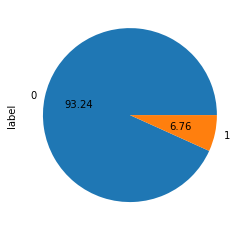

In [16]:
y_train.value_counts().plot.pie(autopct='%0.2f')

In [17]:
# solution:
# Undersampling: reduce majority class to make it equal to minority class
# Oversampling: increase minority class to make it equal to majority class through resampling
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="not majority")
X_train_2d = X_train.values.reshape(-1, 1) # puts each elem of array in own array
X_res, y_res = ros.fit_resample(X_train_2d, y_train)

0    138
1    138
Name: label, dtype: int64

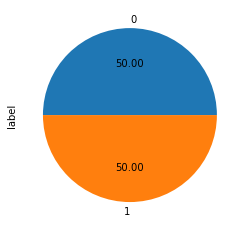

In [18]:
y_res.value_counts().plot.pie(autopct='%0.2f')
y_res.value_counts()

In [20]:
#X_res revert 2_dimensionality
X_res_1d = X_res.flatten()

In [21]:
# classification with resampled vectors
X_res_vect = classification.text2vec(X_res_1d, wv)
X_res_vect_avg = classification.average_vector(X_res_vect)

/Users/jessicahassibi/PycharmProjects/bachelor-thesis/src/models/classification.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  text_vect = np.array([np.array([keyed_vectors[i] for i in sentence if i in words])


In [22]:
# what test vector? also resampled?
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "Random Forest")
# WHY NO SUPPORTED COMPOSERS ?!?!?!?!
classification.print_classification_report(y_test, y_res_pred)

############################################################################
Processing Random Forest Classification

accuracy 0.921875
                      precision    recall  f1-score   support

persecuted composers       1.00      0.92      0.96        64
 supported composers       0.00      0.00      0.00         0

            accuracy                           0.92        64
           macro avg       0.50      0.46      0.48        64
        weighted avg       1.00      0.92      0.96        64

classes in y_pred: {0, 1} classes in y_test: {0}
############################################################################


/Users/jessicahassibi/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jessicahassibi/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jessicahassibi/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [160]:
#from imblearn.pipeline import Pipeline
# create pipeline for handling imbalanced data
#steps = [('over', RandomOverSampler()), ('model', DecisionTreeClassifier())]
#pipeline = Pipeline(steps=steps)

In [161]:
# naive bayes classifier
y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_pred)

############################################################################
Processing Multinomial Naive Bayes Classification

accuracy 0.9375
                      precision    recall  f1-score   support

persecuted composers       1.00      0.94      0.97        32
 supported composers       0.00      0.00      0.00         0

            accuracy                           0.94        32
           macro avg       0.50      0.47      0.48        32
        weighted avg       1.00      0.94      0.97        32

predicted classes: {0, 1} (of classes {0}
############################################################################


/Users/jessicahassibi/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jessicahassibi/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jessicahassibi/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_